### Get data

In [2]:
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

C:\Users\lucas\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df = pd.read_csv('../brooklyn_clean_final.csv', index_col=0)
print(df.columns)

X = df.drop(['SALE_PRICE'], 1)
y = df[['SALE_PRICE']]
y_classified = y.copy(True)
row_num = X.shape[0]

#print(X['11228'])  
#print(X.head(100))

def add_zipcode(zipcodes):
    for zipcode in zipcodes:
        zeros = np.zeros(row_num+1)
        s = pd.Series(zeros)
        key = str(zipcode)
        X[key] = s
        for pos in range(0,row_num):
            if X.iloc[pos]['ZIPCODE'] == zipcode:
                X.set_value(pos+1, key, 1)
                
def add_taxclass(taxclass):
    for tax in taxclass:
        zeros = np.zeros(row_num+1)
        s = pd.Series(zeros)
        key = str(tax)
        X["TAX:"+key] = s
        for pos in range(0,row_num):
            if X.iloc[pos]['TAX_CLASS'] == tax:
                X.set_value(pos+1, "TAX:"+key, 1)
                

def add_buildingclass(buildingclass):
    for building in buildingclass:
        zeros = np.zeros(row_num+1)
        s = pd.Series(zeros)
        key = str(building)
        X["building:"+key] = s
        for pos in range(0,row_num):
            if X.iloc[pos]['TAX_CLASS'] == building:
                X.set_value(pos+1, "building:"+key, 1)

zipcodes = [11239, 11236,11208,11207,11234,11203,11212,11224,11210,
            11229,11233,11228,11204,11214,11221,11209,11235,11213,11223,11220,
            11219,11218,11230,11226,11232,11237,11216,11225,11231,11215,11222,11217,11238,11206,11205,11211,11249,11201]
taxclass = [1,2,4]



add_zipcode(zipcodes)
add_taxclass(taxclass)

# buildingclass = np.arange(1, 219)
#add_buildingclass(buildingclass)


Index(['ZIPCODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'GROSS_SQUARE_FEET',
       'AGE', 'TAX_CLASS', 'SALE_PRICE'],
      dtype='object')


In [4]:
X = X.drop(['ZIPCODE','TAX_CLASS'], 1)
print(X.head(1))

   RESIDENTIAL_UNITS  COMMERCIAL_UNITS  GROSS_SQUARE_FEET  AGE  11239  11236  \
1                  1                 0               1660   87      0      0   

   11208  11207  11234  11203  11212  11224  11210  11229  11233  11228  \
1      0      0      0      0      0      0      0      0      0      1   

   11204  11214  11221  11209  11235  11213  11223  11220  11219  11218  \
1      0      0      0      0      0      0      0      0      0      0   

   11230  11226  11232  11237  11216  11225  11231  11215  11222  11217  \
1      0      0      0      0      0      0      0      0      0      0   

   11238  11206  11205  11211  11249  11201  TAX:1  TAX:2  TAX:4  
1      0      0      0      0      0      0      1      0      0  


change the price value into 1 or 0, depending on whether it satisfies the given condition.

In [5]:
# Set the lower bound of the price
def classify_y(price):
    for pos in range(0,8497):
        if y.iloc[pos]['SALE_PRICE'] >= price:
            if pos < 6:
                print((pos, 1))
            y_classified.set_value(pos+1, 'SALE_PRICE', 1)
        else: 
            y_classified.set_value(pos+1, 'SALE_PRICE',0)
            
# Set the upper bound of the price            
def classify_y_down(price):
    for pos in range(0,8497):
        if y.iloc[pos]['SALE_PRICE'] <= price:
            y_classified.set_value(pos+1, 'SALE_PRICE', 1)
        else: 
            y_classified.set_value(pos+1, 'SALE_PRICE',0)
            
            
def classify_y_range(low, high):
    for pos in range(0,8497):
        if y.iloc[pos]['SALE_PRICE'] <= high and y.iloc[pos]['SALE_PRICE'] >= low:
            y_classified.set_value(pos+1, 'SALE_PRICE', 1)
        else: 
            y_classified.set_value(pos+1, 'SALE_PRICE',0)
            
            
def classify_ranges():
    for pos in range(0,8497):
        if y.iloc[pos]['SALE_PRICE'] <= 200000 and y.iloc[pos]['SALE_PRICE'] >= 0:
            y_classified.set_value(pos+1, 'SALE_PRICE', 1)
        elif y.iloc[pos]['SALE_PRICE'] <= 400000 and y.iloc[pos]['SALE_PRICE'] >= 200000: 
            y_classified.set_value(pos+1, 'SALE_PRICE',2)
        elif y.iloc[pos]['SALE_PRICE'] <= 600000 and y.iloc[pos]['SALE_PRICE'] >= 400000: 
            y_classified.set_value(pos+1, 'SALE_PRICE',3)
        elif y.iloc[pos]['SALE_PRICE'] <= 800000 and y.iloc[pos]['SALE_PRICE'] >= 600000: 
            y_classified.set_value(pos+1, 'SALE_PRICE',4)
        elif y.iloc[pos]['SALE_PRICE'] <= 1000000 and y.iloc[pos]['SALE_PRICE'] >= 800000: 
            y_classified.set_value(pos+1, 'SALE_PRICE',5)
        else: 
            y_classified.set_value(pos+1, 'SALE_PRICE',6)
            
    
            

            

In [6]:
# classify_y_range(100000, 1000000)
# classify_y(1000000)
classify_ranges()

### This is for K means

In [7]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

#digits = load_digits()
data = scale(X.values)

n_samples, n_features = data.shape
n_digits = len(np.unique(y_classified.values))
labels = (y_classified.values).flatten('F')

target_names =np.unique(labels)
print(target_names)

# This might cause some issues
sample_size = 8497

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))
    return estimator

k_means = bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

# bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
#               name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
# pca = PCA(n_components=n_digits).fit(data)
# bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
#               name="PCA-based",
#               data=data)
print(79 * '_')



[1 2 3 4 5 6]
n_digits: 6, 	 n_samples 8497, 	 n_features 45
_______________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette
k-means++   0.46s    329687   0.070   0.107   0.085   0.012   0.069    0.043
_______________________________________________________________________________


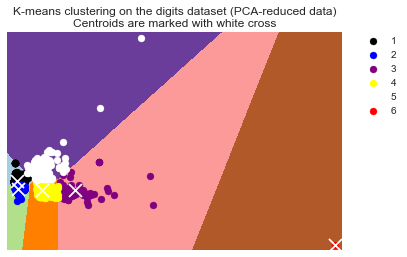

In [9]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

colors = ['black', 'blue', 'purple', 'yellow', 'white', 'red', 'lime', 'cyan', 'orange', 'gray']
#plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
for i in range(len(colors)):
    x = reduced_data[:, 0][labels == i] #replace digits.target with labels becauset they are the same thing in the other notebook
    y = reduced_data[:, 1][labels == i]
    
    x = reduced_data[:, 0][kmeans.labels_ == i]
    y = reduced_data[:, 1][kmeans.labels_ == i]
    plt.scatter(x, y, c=colors[i])
    
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

plt.legend(target_names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(target_names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(())
plt.yticks(())
plt.show()

### Predict

In [10]:
data = {'RESIDENTIAL_UNITS':0, 'COMMERCIAL_UNITS':0, 'GROSS_SQUARE_FEET':10000, 'AGE':0, '11239':0,'11236':0,'11208':0,'11207':0,'11234':0,'11203':1,'11212':0,'11224':0,'11210':0,'11229':0,'11233':0,'11228':0,'11204':0,'11214':0,'11221':0,'11209':0,'11235':0,'11213':0,'11223':0,'11220':0,
             '11219':1,'11218':0,'11230':0,'11226':0,'11232':0,'11237':0,'11216':0,'11225':0,'11231':0,'11215':0,'11222':0,'11217':0,'11238':0,'11206':0,'11205':0,'11211':0,'11249':0,'11201':0,'TAX:1':1,'TAX:2':0,'TAX:4':0}

#data={'ZIPCODE':11239,'RESIDENTIAL_UNITS':1, 'COMMERCIAL_UNITS':1, 'GROSS_SQUARE_FEET':1000,'AGE':0,'TAX_CLASS':1}  

#id_f = {s: data[s] for s in col}
df_user=pd.DataFrame(data=data, 
                     index=np.arange(1)
                    )
df_user.head(1)
#print(df_user.dtypes)

,11201,11203,11204,11205,11206,11207,11208,11209,11210,11211,11212,11213,11214,11215,11216,11217,11218,11219,11220,11221,11222,11223,11224,11225,11226,11228,11229,11230,11231,11232,11233,11234,11235,11236,11237,11238,11239,11249,AGE,COMMERCIAL_UNITS,GROSS_SQUARE_FEET,RESIDENTIAL_UNITS,TAX:1,TAX:2,TAX:4
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10000,0,1,0,0


In [11]:
print(k_means.predict(df_user))

[2]
